# BT4012 Kaggle Competition

Author: Loh Hong Tak Edmund

Python Version: 3.8.11

# plan:

- EDA
- Scaling
- RFE
- Models:
    - XGBoost
    - RandomForest
    - Logit
    - Neural Network: CNN + LSTM

## Importing packages

In [6]:
!pip install xgboost

  Using cached xgboost-1.4.2-py3-none-win_amd64.whl (97.8 MB)


In [209]:
# Loading Packages

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from numpy import sort

from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, roc_auc_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import xgboost

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import TextVectorization
from keras.regularizers import l2

# Settings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [3]:
def getRFEfeatures(model, x, y, n_features_to_select):
    rfe = RFE(model, n_features_to_select)
    rfe = rfe.fit(x,y)
    selected_features = list(x.columns[rfe.support_])
    print('Selected features: %s' % selected_features)
    return selected_features

def get_auc(model, x, y):
    y_pred_proba = model.predict_proba(x)[:,1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)
    return auc(fpr, tpr)

def get_logloss(model, x, y):
    y_pred_proba = model.predict_proba(x)[:,1]
    return log_loss(y, y_pred_proba)

def print_train_score(model, x_train, y_train, auc=True):
    pred = model.predict(x_train)
    model_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
    print("TRAIN RESULT:\n================================================")
    print(f"ACCURACY SCORE: {accuracy_score(y_train, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{model_report}")
    print("_______________________________________________")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_train, pred)}\n")
    if auc:
        print("_______________________________________________")
        print(f"AUC Score: \n {get_auc(model, x_train, y_train)}\n")
    
def print_test_score(model, x_test, y_test, auc=True):
    pred = model.predict(x_test)
    model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
    print("TEST RESULT:\n================================================")
    print(f"ACCURACY SCORE: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{model_report}")
    print("_______________________________________________")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_test, pred)}\n")
    if auc:
        print("_______________________________________________")
        print(f"AUC Score: \n {get_auc(model, x_test, y_test)}\n")

def predict_to_csv(model,ds,name):
    pred = model.predict(ds)
    pred_df = pd.DataFrame({'Id':Id, 'Predicted':predictions}, columns=['Id', 'Predicted'])
    pred_df.to_csv('%s.csv'%(name), index=False)
    return True

## Loading Dataset

In [4]:
ds = pd.read_csv('train.csv')

In [20]:
ds.head()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
0,1,1,1,1,28,43,52,255,255,255,...,191,255,52,34,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,128,255,255,255,255,255,255,255,...,255,255,255,255,255,255,128,1,1,0
3,53,54,61,91,141,172,197,223,233,246,...,184,185,187,169,147,106,82,34,23,1
4,46,46,46,46,36,36,41,41,41,41,...,38,65,65,95,95,149,149,205,205,0


In [25]:
ds.label

0        0
1        0
2        0
3        1
4        0
        ..
72134    0
72135    0
72136    0
72137    0
72138    0
Name: label, Length: 72139, dtype: int64

In [32]:
counter = Counter
counter(ds.label)

Counter({0: 65581, 1: 6558})

In [15]:
ds.describe()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
count,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,...,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000,72139.000000
mean,36.125383,51.473308,70.855279,82.032354,86.869142,96.391730,101.608728,108.712333,115.257752,119.014680,...,105.187416,101.996327,98.175689,94.994663,83.791611,79.024744,67.467084,49.497775,37.186349,0.090908
std,70.769428,83.545299,93.468985,99.787787,100.295541,103.128587,104.129642,103.806258,106.480366,107.572306,...,106.387324,102.402083,103.242319,102.317456,98.440790,97.781003,90.884177,82.706445,72.454911,0.287480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,18.000000,33.000000,52.000000,67.000000,91.000000,96.000000,104.000000,...,69.000000,73.000000,60.000000,52.000000,26.000000,7.000000,1.000000,1.000000,1.000000,0.000000
75%,30.000000,80.000000,128.000000,171.000000,181.000000,208.000000,219.000000,226.000000,248.000000,255.000000,...,236.000000,213.000000,207.000000,199.000000,172.000000,163.000000,128.000000,73.000000,24.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [9]:
X = ds.drop('label', axis=1)

In [33]:
X.shape

(72139, 400)

In [34]:
X_mat = []
for i in range(X.shape[0]):
    X_mat.append(np.reshape(X.iloc[i].tolist(), (20,20)).T)

In [88]:
X_mat_arr = np.array(X_mat)

In [89]:
X_mat_arr.shape

(72139, 20, 20)

In [91]:
X_mat_arr_ex = X_mat_arr[:,:,:,None]

In [92]:
X_mat_arr_ex.shape

(72139, 20, 20, 1)

In [93]:
y = ds.label.values


In [94]:
x_train, x_test, y_train, y_test = train_test_split(X_mat_arr_ex, y, test_size=0.20, random_state=0)


In [95]:
x_train.shape

(57711, 20, 20, 1)

In [96]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(str(label_batch[n]))
        plt.axis("off")

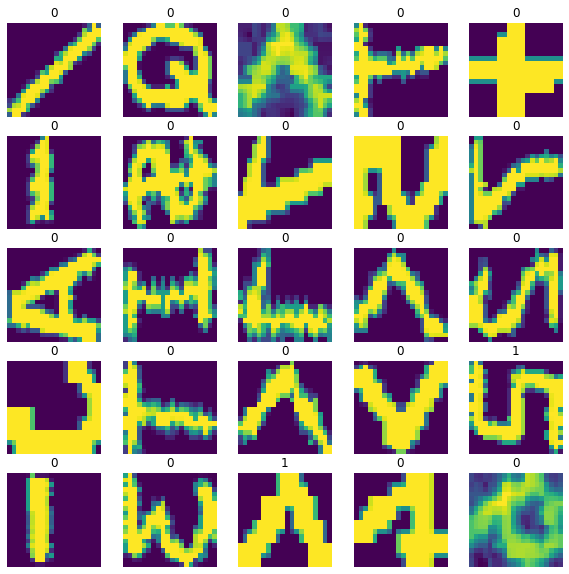

In [97]:
show_batch(x_train, y_train)


In [142]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,y_train, epochs=10, batch_size=32)

Epoch 1/10
1804/1804 [==============================] - 6s 3ms/step - loss: 1.0467 - accuracy: 0.9176
Epoch 2/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1604 - accuracy: 0.9485
Epoch 3/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1462 - accuracy: 0.9532
Epoch 4/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1410 - accuracy: 0.9544
Epoch 5/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1288 - accuracy: 0.9590
Epoch 6/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1195 - accuracy: 0.9612
Epoch 7/10
1804/1804 [==============================] - 5s 3ms/step - loss: 0.1102 - accuracy: 0.9637
Epoch 8/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.1011 - accuracy: 0.9673
Epoch 9/10
1804/1804 [==============================] - 6s 3ms/step - loss: 0.0946 - accuracy: 0.9700
Epoch 10/10
1804/1804 [==============================] - 6s 4ms/step - loss: 0.088

In [227]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001)),
        tf.keras.layers.Conv2D(filters, (3, 3), activation = 'relu', kernel_regularizer=l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [234]:
model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(20, 20, 1)),
    #layers.Dropout(0.5),
    conv_block(64),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    layers.Dropout(0.5),
    conv_block(128),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    layers.Dropout(0.5),
    conv_block(256),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    layers.Dropout(0.5),
    conv_block(512),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [235]:
#model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

In [195]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [236]:
history = model.fit(
    x_train, y_train, 
    epochs= 40, 
    batch_size = 64, 
    validation_split=0.1,
    callbacks=[early_stopping_cb]
)

Epoch 1/40
812/812 [==============================] - 56s 66ms/step - loss: 0.4916 - accuracy: 0.9052 - auc: 0.6997 - val_loss: 0.4170 - val_accuracy: 0.9220 - val_auc: 0.7519
Epoch 2/40
812/812 [==============================] - 57s 70ms/step - loss: 0.3603 - accuracy: 0.9167 - auc: 0.8153 - val_loss: 0.3610 - val_accuracy: 0.9255 - val_auc: 0.8067
Epoch 3/40
453/812 [===============>..............] - ETA: 23s - loss: 0.3001 - accuracy: 0.9200 - auc: 0.8635

In [208]:
score = model.evaluate(x_test, y_test, batch_size=64)

226/226 [==============================] - 5s 22ms/step - loss: 0.0902 - accuracy: 0.9681 - auc: 0.9735


## Splitting Training and Testing Data

In [33]:
X = ds.drop('label', axis=1)
y = ds.label.values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


## XGBoost (Base)

In [170]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(x_train,y_train)


ValueError: Please reshape the input data X into 2-dimensional matrix.

In [47]:
print_train_score(xgb, x_train,y_train)


TRAIN RESULT:
ACCURACY SCORE: 99.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999695     0.997721  0.999515      0.998708      0.999515
recall         0.999771     0.996963  0.999515      0.998367      0.999515
f1-score       0.999733     0.997342  0.999515      0.998537      0.999515
support    52442.000000  5269.000000  0.999515  57711.000000  57711.000000
_______________________________________________
CONFUSION MATRIX: 
 [[52430    12]
 [   16  5253]]

_______________________________________________
AUC Score: 
 0.9999885656649199



In [48]:
print_test_score(xgb, x_test,y_test)


TEST RESULT:
ACCURACY SCORE: 97.52%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.978009     0.939566  0.975187      0.958787      0.974574
recall         0.995129     0.771916  0.975187      0.883523      0.975187
f1-score       0.986495     0.847530  0.975187      0.917012      0.974080
support    13139.000000  1289.000000  0.975187  14428.000000  14428.000000
_______________________________________________
CONFUSION MATRIX: 
 [[13075    64]
 [  294   995]]

_______________________________________________
AUC Score: 
 0.9880131111099434



## XGBoost (Feature Selection)

In [70]:
thresholds = sort(xgb.feature_importances_)
store = {}

for thresh in thresholds[:50]:
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    selection_model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    selection_model.fit(select_x_train, y_train)
    select_x_test = selection.transform(x_test)
    predictions = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test,predictions)
    n = select_x_train.shape[1]
    roc_auc = roc_auc_score(y_test, selection_model.predict_proba(select_x_test)[:, 1])
    store[n] = {"Threshold": thresh, "Accuracy": accuracy, "F1-Score": f1, "ROC_AUC": roc_auc, "Model": selection_model, "Selection": selection}
    print("Thresh=%.3f, n=%d, Accuracy: %.3f%%, F1-score: %.3f, ROC_AUC: %.3f" % (thresh, n , accuracy*100.0, f1, roc_auc))
    


Thresh=0.000, n=400, Accuracy: 97.519%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.000, n=399, Accuracy: 97.449%, F1-score: 0.843, ROC_AUC: 0.989
Thresh=0.000, n=398, Accuracy: 97.449%, F1-score: 0.843, ROC_AUC: 0.988
Thresh=0.000, n=397, Accuracy: 97.415%, F1-score: 0.840, ROC_AUC: 0.987
Thresh=0.001, n=396, Accuracy: 97.540%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.001, n=395, Accuracy: 97.408%, F1-score: 0.840, ROC_AUC: 0.987
Thresh=0.001, n=394, Accuracy: 97.463%, F1-score: 0.844, ROC_AUC: 0.988
Thresh=0.001, n=393, Accuracy: 97.533%, F1-score: 0.848, ROC_AUC: 0.988
Thresh=0.001, n=392, Accuracy: 97.491%, F1-score: 0.845, ROC_AUC: 0.988
Thresh=0.001, n=391, Accuracy: 97.526%, F1-score: 0.847, ROC_AUC: 0.990
Thresh=0.001, n=390, Accuracy: 97.456%, F1-score: 0.844, ROC_AUC: 0.989
Thresh=0.001, n=389, Accuracy: 97.422%, F1-score: 0.841, ROC_AUC: 0.988
Thresh=0.001, n=388, Accuracy: 97.436%, F1-score: 0.841, ROC_AUC: 0.988
Thresh=0.001, n=387, Accuracy: 97.491%, F1-score: 0.845, ROC_AUC

In [76]:
thresh_re = pd.DataFrame(store).T

In [133]:
thresh_re.head()

,Threshold,Accuracy,F1-Score,ROC_AUC,Model,Selection,Accuracy\t
400,0.000397,0.975187,0.847530,0.988013,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.975187
399,0.000409,0.974494,0.842601,0.988947,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974494
398,0.000420,0.974494,0.843137,0.988064,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974494
397,0.000437,0.974147,0.840394,0.987188,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.974147
396,0.000511,0.975395,0.848485,0.988470,"XGBClassifier(base_score=0.5, booster='gbtree'...",SelectFromModel(estimator=XGBClassifier(base_s...,0.975395


In [123]:
thresh_re['ROC_AUC'] =pd.to_numeric(thresh_re['ROC_AUC'])
thresh_re['Threshold'] =pd.to_numeric(thresh_re['Threshold'])
thresh_re['Accuracy'] =pd.to_numeric(thresh_re['Accuracy'])
thresh_re['F1-Score'] =pd.to_numeric(thresh_re['F1-Score'])

In [124]:
best_thresh = thresh_re.loc[thresh_re['Accuracy'].idxmax()]
best_thresh

Threshold                                              0.000511
Accuracy                                               0.975395
F1-Score                                               0.848485
ROC_AUC                                                 0.98847
Model         XGBClassifier(base_score=0.5, booster='gbtree'...
Selection     SelectFromModel(estimator=XGBClassifier(base_s...
Accuracy\t                                             0.975395
Name: 396, dtype: object

In [88]:
best_select = store[391]["Selection"]
best_model = store[391]["Model"]


## Neural Networks

In [223]:
nn_model = tf.keras.Sequential([
    #layers.InputLayer(input_shape=(None,), dtype="float"),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

In [224]:
nn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'AUC'])

In [215]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [248]:
BATCH_SIZE = 64
EPOCHS = 128

history = nn_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/128
812/812 [==============================] - 7s 8ms/step - loss: 0.1121 - accuracy: 0.9625 - auc: 0.9639 - val_loss: 0.1125 - val_accuracy: 0.9550 - val_auc: 0.9710
Epoch 2/128
812/812 [==============================] - 9s 12ms/step - loss: 0.1083 - accuracy: 0.9643 - auc: 0.9656 - val_loss: 0.1085 - val_accuracy: 0.9589 - val_auc: 0.9686
Epoch 3/128
812/812 [==============================] - 10s 12ms/step - loss: 0.1112 - accuracy: 0.9642 - auc: 0.9635 - val_loss: 0.1123 - val_accuracy: 0.9582 - val_auc: 0.9728
Epoch 4/128
812/812 [==============================] - 9s 11ms/step - loss: 0.1070 - accuracy: 0.9641 - auc: 0.9682 - val_loss: 0.1250 - val_accuracy: 0.9581 - val_auc: 0.9691
Epoch 5/128
812/812 [==============================] - 9s 11ms/step - loss: 0.1052 - accuracy: 0.9649 - auc: 0.9685 - val_loss: 0.1040 - val_accuracy: 0.9641 - val_auc: 0.9698
Epoch 6/128
812/812 [==============================] - 11s 14ms/step - loss: 0.1055 - accuracy: 0.9648 - auc: 0.9680 - v

In [229]:
score = nn_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)


226/226 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.9582 - auc: 0.9733


# Testing on Test Data

In [131]:
test_ds = pd.read_csv("test.csv")
Id = test_ds['Id'][:]
test_ds = test_ds.drop("Id", axis=1)

## XGB with 391 Features

In [244]:
test_transform = best_select.transform(test_ds)
predictions = best_model.predict(test_transform)
predict_to_csv(best_model, test_transform,"predictions_xgb_391")

True

## XGB with all Features

In [130]:
predict_to_csv(xgb,test_ds,"predictions_xgb")

True

In [245]:
predict_to_csv(nn_model,test_ds,"prediction_nn1")

True

In [246]:
a = pd.read_csv("predictions_xgb_391.csv")
b = pd.read_csv("prediction_nn1.csv")

In [247]:
sum(a.Predicted - b.Predicted)

0